In [2]:
%load_ext autoreload
%autoreload 2

In [148]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import scipy
from scipy.stats import sem
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import pyret
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.notebook.functions import *
import kinetic.models as models
from kinetic.models import *
from torchdeepretina.utils import *

In [143]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-62.71_pearson_natural_0.4564_pearson_noise_0.4508.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_020_loss_1.44_pearson_0.4672.pth'
cfg_name = 'kinetics_both2'
cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

data_kwargs = dict(cfg.Data)

In [19]:
stats = {'mean': 127.54951851851852, 'std': 28.607890356944278}
fullfield_dataset = MyDataset('validation', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield', 0, stats=stats, cells=[1,2,7,10])
fullfield_data =  DataLoader(fullfield_dataset)
pearson, val_pred, val_targ = pearsonr_eval(model, fullfield_data, 4, device, with_responses=True)

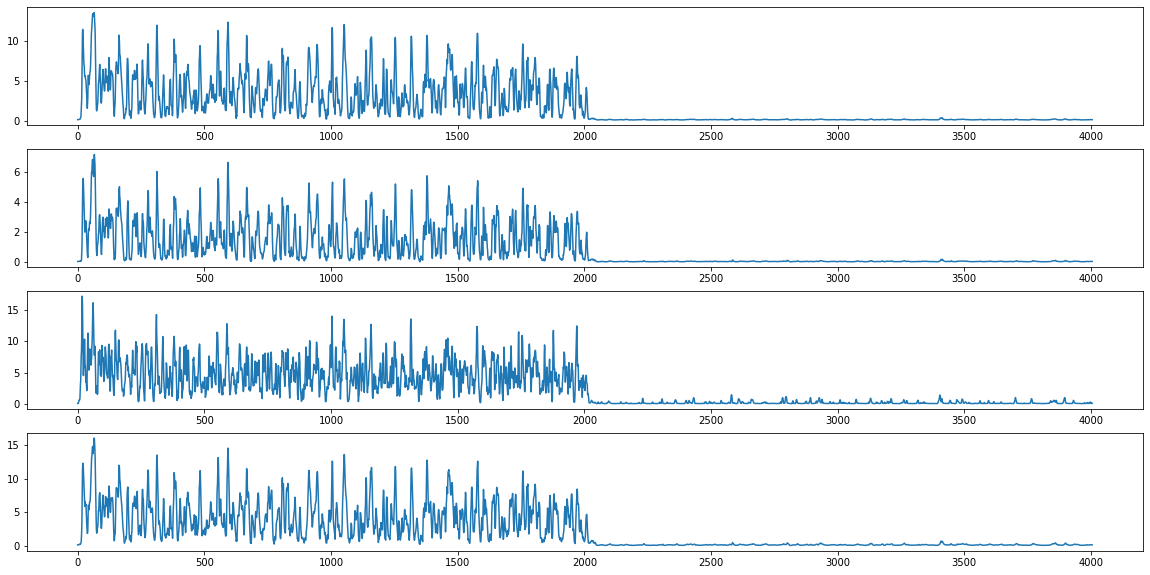

In [20]:
responses = val_pred[3966:40020, :].reshape((9, -1, 4))
fig,ax = plt.subplots(4,1,figsize=(20,10))
for i in range(4):
    ax[i].plot(responses.mean(0)[:, i])
plt.show()

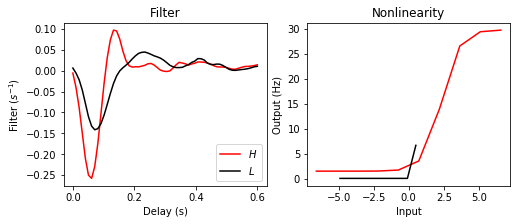

In [21]:
c1 = 0.35
c0 = 0.05
nrepeats = 10
envelope = c1 * np.ones((4000, 1, 1))
envelope[2000:4000] = c0
envelope = np.concatenate([envelope for _ in range(nrepeats)])
stimulus = random_from_envelope(envelope, repeat=3)
stimulus = 4.46 * stimulus
stimulus_rolling = stim.concat(stimulus, nh=40)
hs = get_hs(model, 1, device, None, 'single')
val_pred = []
with torch.no_grad():
    for idx in range(stimulus_rolling.shape[0]):
        x = torch.from_numpy(stimulus_rolling[idx:idx+1]).to(device)
        out, hs = model(x, hs)
        val_pred.append(out.detach().cpu().numpy().squeeze(0))
    val_pred = np.stack(val_pred, axis=0)
    
responses = val_pred[3960:, :].reshape((9, -1, 4))
responses = [resp for resp in responses]
stimuli = stimulus.squeeze().reshape(10, -1)[1:]
stimuli = [stim+4.46 for stim in stimuli]

sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=2, start_idx=0, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.05, cell=2, start_idx=2000, end_idx=4000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

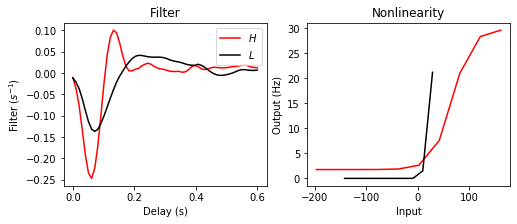

In [25]:
with h5py.File('/home/xhding/tem_stim/21-01-26/fullfield.h5', 'r') as f:
    stimulus =  np.asarray(f['train']['stimulus']).astype('float32')
stimulus = (stimulus - 127.5)/28.6
stimulus_rolling = stim.concat(stimulus, nh=40)
hs = get_hs(model, 1, device, None, 'single')
val_pred = []
with torch.no_grad():
    for idx in range(stimulus_rolling.shape[0]):
        x = torch.from_numpy(stimulus_rolling[idx:idx+1]).to(device)
        out, hs = model(x, hs)
        val_pred.append(out.detach().cpu().numpy().squeeze(0))
    val_pred = np.stack(val_pred, axis=0)

responses = val_pred[3966:40020, :].reshape((9, -1, 4))
responses = [resp for resp in responses]
stimuli = stimulus[:40060,25,25].reshape(10, -1)[1:]
stimuli = [stim*28.6+127.5 for stim in stimuli]

sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=2, start_idx=0, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.05, cell=2, start_idx=2000, end_idx=4000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

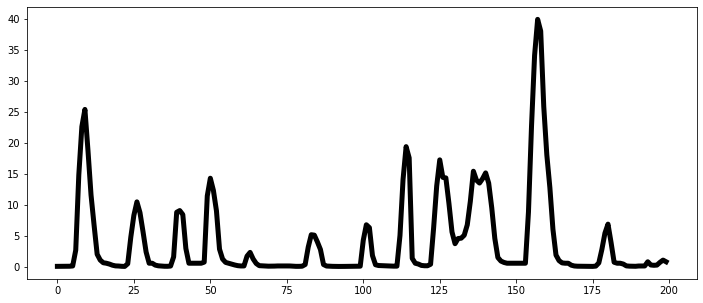

In [58]:
plt.figure(figsize=(12,5))
plt.plot(responses[0][1000:1200,2], color='black', linewidth=5)

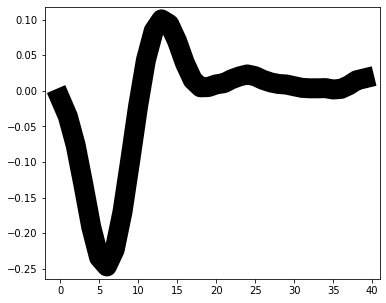

In [37]:
plt.figure(figsize=(6,5))
plt.plot(sta_h[:40], color='black', linewidth=20)

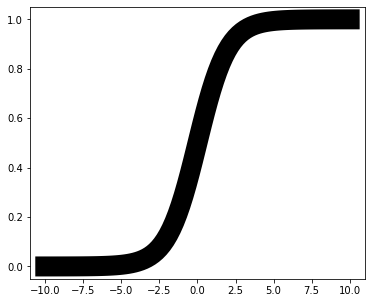

In [42]:
plt.figure(figsize=(6,5))
x = np.linspace(-10, 10, 100)
plt.plot(x, 1/(1+np.exp(-x)), color='black', linewidth=20)

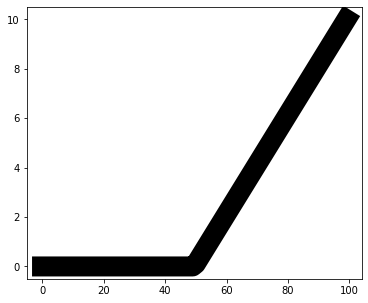

In [47]:
plt.figure(figsize=(6,5))
x = np.linspace(-10, 10, 100)
x[x<0] = 0
plt.plot(x, color='black', linewidth=20)

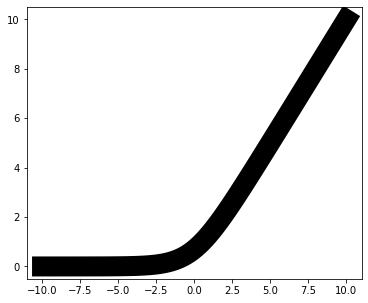

In [48]:
plt.figure(figsize=(6,5))
x = np.linspace(-10, 10, 100)
plt.plot(x, np.log(1+np.exp(x)), color='black', linewidth=20)

seed= 0


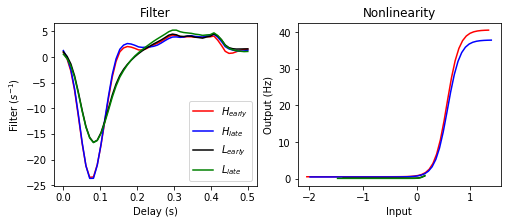

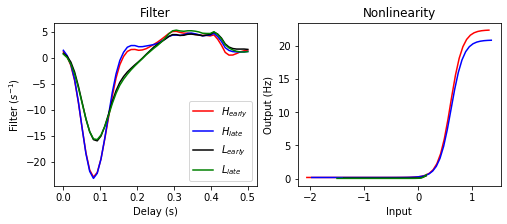

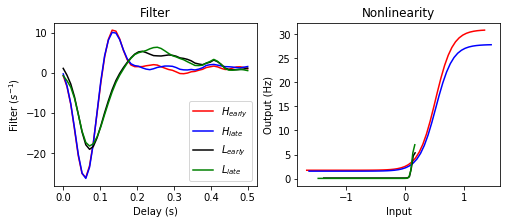

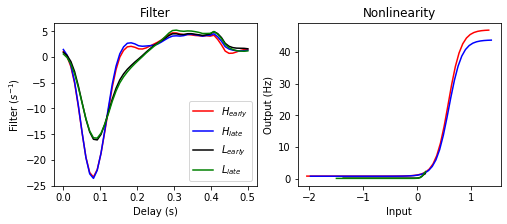

seed= 6


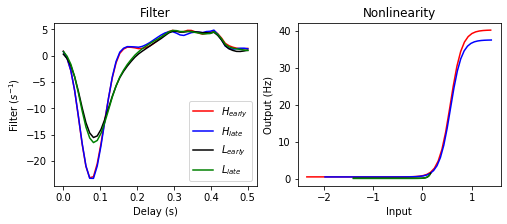

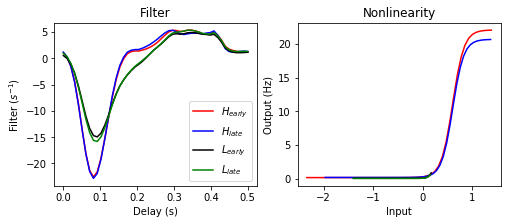

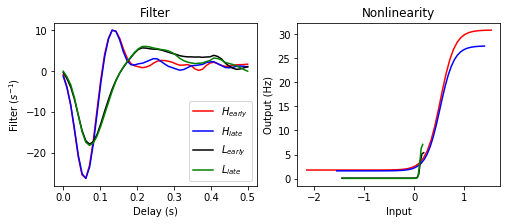

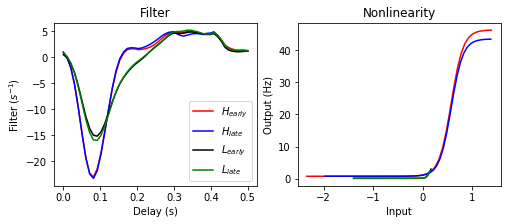

seed= 12


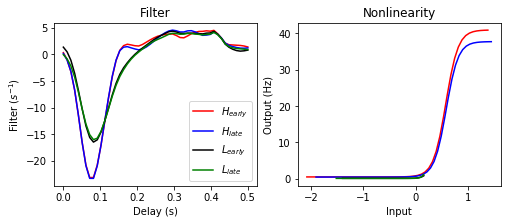

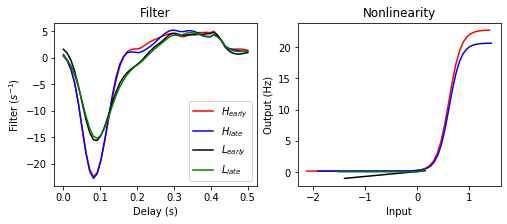

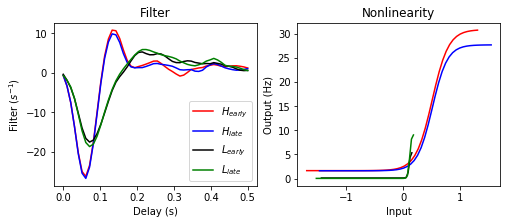

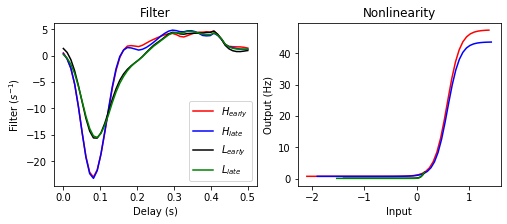

seed= 17


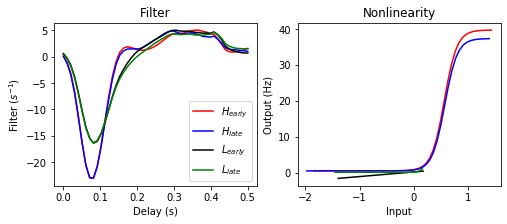

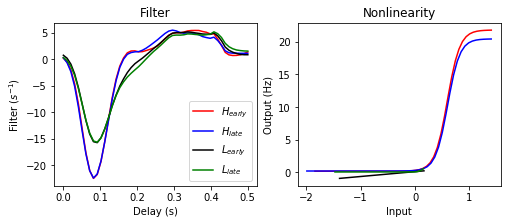

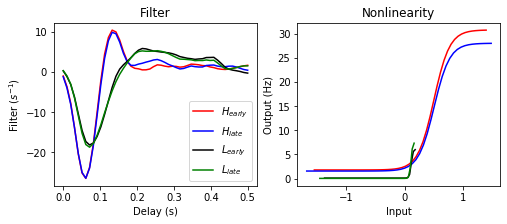

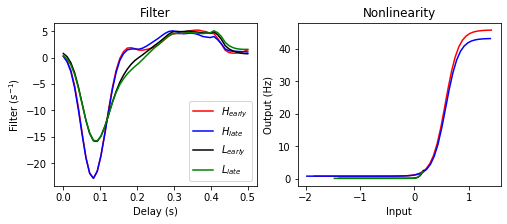

seed= 25


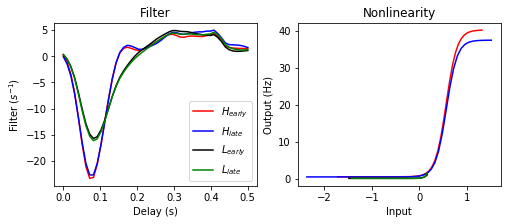

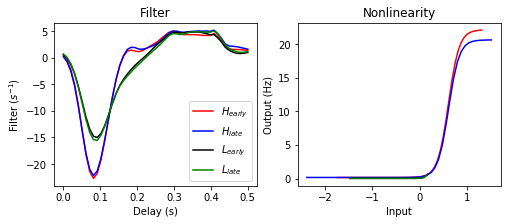

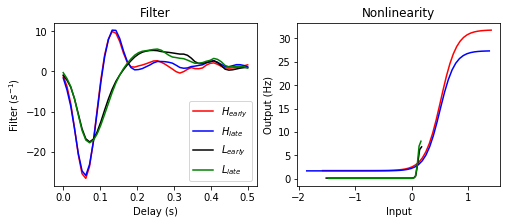

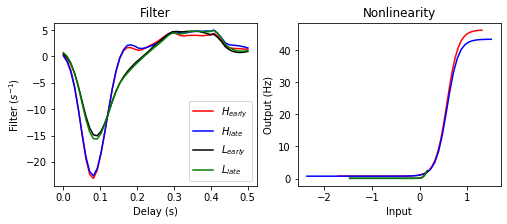

seed= 48


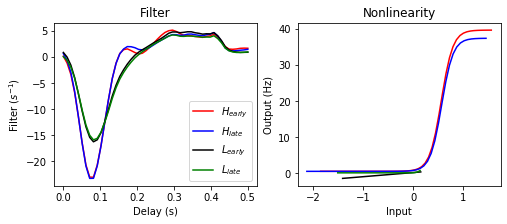

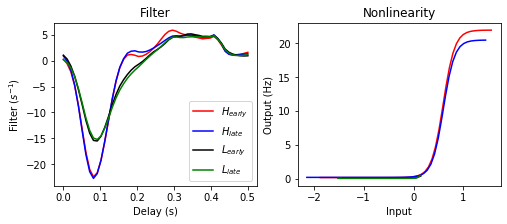

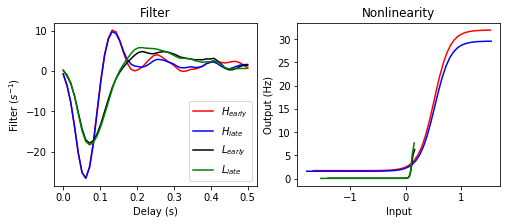

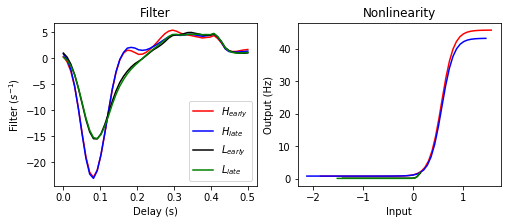

seed= 49


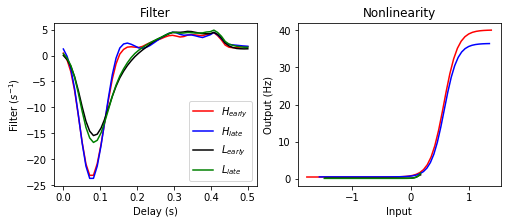

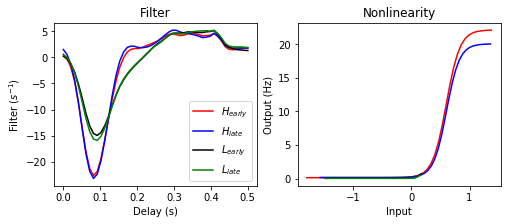

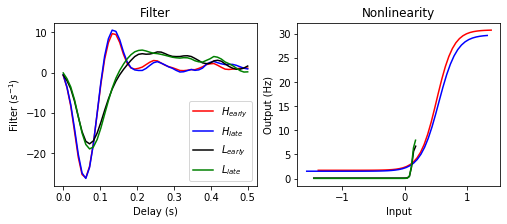

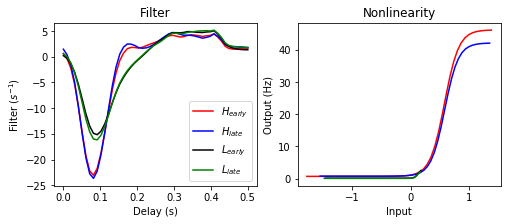

In [200]:
c0=0.05
c1=0.35
nrepeats=100
for i in [0,6,12,17,25,48,49]:
    np.random.seed(i)
    print('seed=', i)
    stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=3, **data_kwargs)

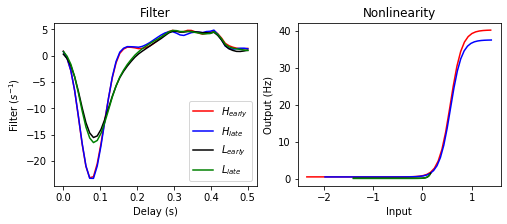

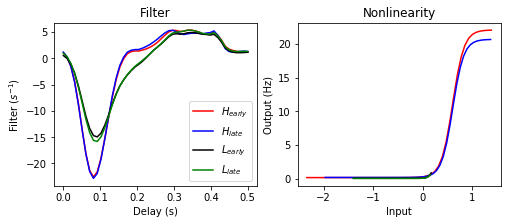

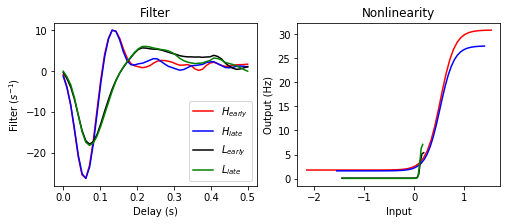

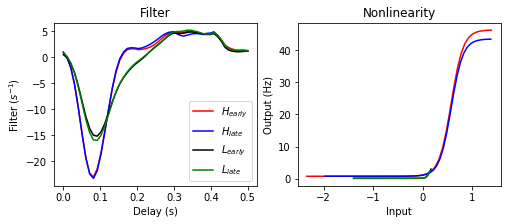

In [202]:
c0=0.05
c1=0.35
nrepeats=100
np.random.seed(6)
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=3, **data_kwargs)

In [64]:
with open('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/stimuli/stimuli.npy', 'wb') as f:
    np.save(f, np.array(stimuli))
    f.close()

In [71]:
with open('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/stimuli/stimuli.npy', 'rb') as f:
    stimuli = np.load(f)
    stimuli = [stim for stim in stimuli]

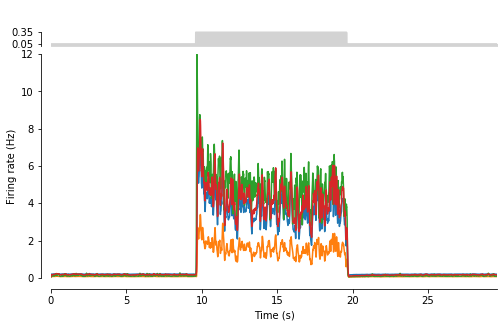

In [66]:
figs, layer_outs = contrast_adaptation_kinetic(model, device, ['kinetics'], scale=4.46, c0=0.05, c1=0.35, fpf=3, nrepeats=100, load_stimuli=stimuli)

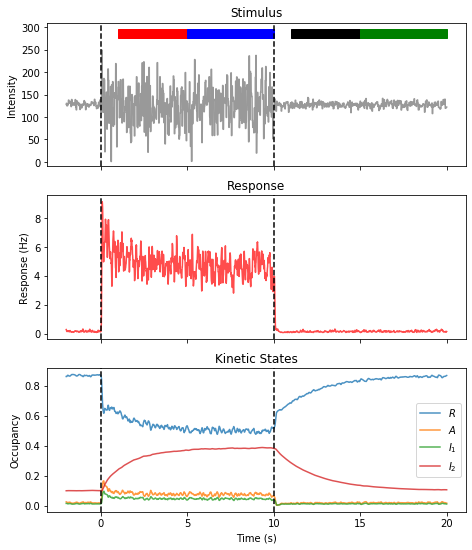

In [79]:
fig, axes = plt.subplots(3,1, figsize=(7.5,9), sharex=True)
for trial in range(len(stimuli)):
    stimuli[trial][stimuli[trial]>2.] = 2.
    stimuli[trial][stimuli[trial]<0.] = 0.
axes[0].plot(np.linspace(-2, 20, 2200), 127.5*stimuli[0][800:], color='gray', alpha=0.8)
axes[0].axvline(x=0, color='black', ls='--')
axes[0].axvline(x=10, color='black', ls='--')
axes[0].set_ylabel('Intensity')
axes[0].set_title('Stimulus')
axes[0].set_ylim((-10, 310))
axes[0].add_patch(patches.Rectangle((1, 275), 4, 20, color='red'))
axes[0].add_patch(patches.Rectangle((5, 275), 5, 20, color='blue'))
axes[0].add_patch(patches.Rectangle((11, 275), 4, 20, color='black'))
axes[0].add_patch(patches.Rectangle((15, 275), 5, 20, color='green'))

axes[1].plot(np.linspace(-2, 20, 2200), np.array(responses).mean(0)[800:, 2], color='r', alpha=0.7)
axes[1].axvline(x=0, color='black', ls='--')
axes[1].axvline(x=10, color='black', ls='--')
axes[1].set_ylabel('Response (Hz)')
axes[1].set_title('Response')

channel = 4
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 0, channel], label=r'$R$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 1, channel], label=r'$A$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 2, channel], label=r'$I_1$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 3, channel], label=r'$I_2$', alpha=0.8)
axes[2].legend()
axes[2].axvline(x=0, color='black', ls='--')
axes[2].axvline(x=10, color='black', ls='--')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Occupancy')
axes[2].set_title('Kinetic States')

plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/response.png', dpi=300,  bbox_inches = "tight")

In [188]:
n_units = 4
data_kwargs = dict(cfg.Data)

data_kwargs['stim'] = 'fullfield_whitenoise'
cfg.Data.start_idx = 4000

train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs))
test_pc_noise, error_noise = pearsonr_eval(model, test_data_noise, n_units, device, I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs), shuffle=True)
test_pc_noise_shuffle, error_noise_shuffle = pearsonr_eval(model, test_data_noise, n_units, device, I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

cfg.Data.start_idx = 0
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs))
test_pc_natural, error_natural = pearsonr_eval(model, test_data_natural, n_units, device,
                                I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs), shuffle=True)
test_pc_natural_shuffle, error_natural_shuffle = pearsonr_eval(model, test_data_natural, n_units, device,
                                I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

ksr, ksi = model.kinetics.ksr.data, model.kinetics.ksi.data
model.kinetics.ksr.data = torch.tensor([[0.]]).to(device)
model.kinetics.ksi.data = torch.tensor([[0.]]).to(device)

data_kwargs['stim'] = 'fullfield_whitenoise'
cfg.Data.start_idx = 4000

train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs))
test_pc_noise_fast, error_noise_fast = pearsonr_eval(model, test_data_noise, n_units, device, I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

cfg.Data.start_idx = 0
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs))
test_pc_natural_fast, error_natural_fast = pearsonr_eval(model, test_data_natural, n_units, device, I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

model.kinetics.ksr.data, model.kinetics.ksi.data = ksr, ksi

In [193]:
corr_natural = np.array([0.7118, 0.8057, 0.7835, 0.7989])
corr_noise = np.array([0.7134, 0.6254, 0.7281, 0.7501])
#corr_natural = np.array([0.5998774678015877, 0.7685088734628157, 0.7436662407746513, 0.7459624327025252])
#corr_noise = np.array([0.604101774208534, 0.42667812190285226, 0.7209186358416417, 0.6714895859346826])

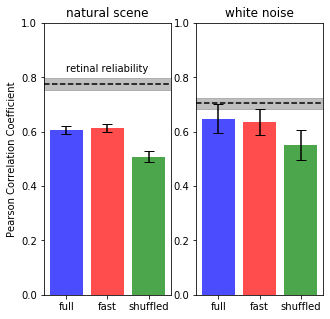

In [195]:
fig, axes = plt.subplots(1,2, figsize=(5,5))

rects1 = axes[0].bar(['full', 'fast', 'shuffled'], [test_pc_natural, test_pc_natural_fast, test_pc_natural_shuffle], capsize=5,
                     yerr=[error_natural, error_natural_fast, error_natural_shuffle], color=['blue', 'red', 'green'], alpha=0.7)

axes[0].axhline(y=corr_natural.mean(), linestyle='--', color='black')
axes[0].axhspan(ymin=corr_natural.mean()-sem(corr_natural), ymax=corr_natural.mean()+sem(corr_natural), color='gray', alpha=0.5)

axes[0].text(0, 0.82, 'retinal reliability')
axes[0].set_ylabel('Pearson Correlation Coefficient')
axes[0].set_ylim([0, 1])
axes[0].set_title('natural scene')

rects1 = axes[1].bar(['full', 'fast', 'shuffled'], [test_pc_noise, test_pc_noise_fast, test_pc_noise_shuffle], capsize=5,
                     yerr=[error_noise, error_noise_fast, error_noise_shuffle], color=['blue', 'red', 'green'], alpha=0.7)
axes[1].axhline(y=corr_noise.mean(), linestyle='--', color='black')
axes[1].axhspan(ymin=corr_noise.mean()-sem(corr_natural), ymax=corr_noise.mean()+sem(corr_natural), color='gray', alpha=0.5)
axes[1].set_ylim([0, 1])
axes[1].set_title('white noise')

plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/pearson.png', dpi=300,  bbox_inches = "tight")
plt.show()

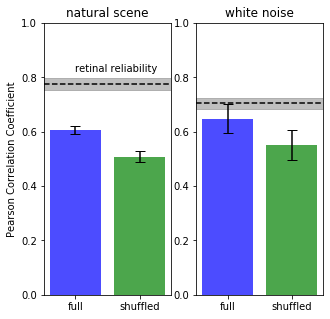

In [206]:
fig, axes = plt.subplots(1,2, figsize=(5,5))

rects1 = axes[0].bar(['full', 'shuffled'], [test_pc_natural, test_pc_natural_shuffle], capsize=5,
                     yerr=[error_natural, error_natural_shuffle], color=['blue', 'green'], alpha=0.7)

axes[0].axhline(y=corr_natural.mean(), linestyle='--', color='black')
axes[0].axhspan(ymin=corr_natural.mean()-sem(corr_natural), ymax=corr_natural.mean()+sem(corr_natural), color='gray', alpha=0.5)

axes[0].text(0, 0.82, 'retinal reliability')
axes[0].set_ylabel('Pearson Correlation Coefficient')
axes[0].set_ylim([0, 1])
axes[0].set_title('natural scene')

rects1 = axes[1].bar(['full', 'shuffled'], [test_pc_noise, test_pc_noise_shuffle], capsize=5,
                     yerr=[error_noise, error_noise_shuffle], color=['blue', 'green'], alpha=0.7)
axes[1].axhline(y=corr_noise.mean(), linestyle='--', color='black')
axes[1].axhspan(ymin=corr_noise.mean()-sem(corr_natural), ymax=corr_noise.mean()+sem(corr_natural), color='gray', alpha=0.5)
axes[1].set_ylim([0, 1])
axes[1].set_title('white noise')

plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/pearson.png', dpi=300,  bbox_inches = "tight")
plt.show()

In [98]:
cfg.Data.start_idx = 0
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs))
test_pc_natural, val_pred, val_targ, error_natural = pearsonr_eval(model, test_data_natural, n_units, device,
                                                                   I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode, with_responses=True)

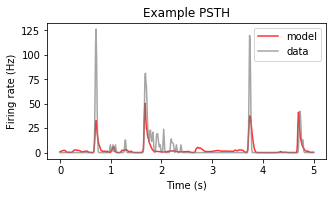

In [123]:
fig, axe = plt.subplots(1,1, figsize=(5,2.5))
start = 900
end = start+500
cell = 2
axe.plot(np.linspace(0, (end-start)/100., end-start), val_pred[start:end, cell], label='model', color='red', alpha=0.8)
axe.plot(np.linspace(0, (end-start)/100., end-start), val_targ[start:end, cell], label='data', color='gray', alpha=0.7)
axe.set_xlabel('Time (s)')
axe.set_ylabel('Firing rate (Hz)')
axe.set_title('Example PSTH')
axe.legend()
plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/psth.png', dpi=300,  bbox_inches = "tight")

In [199]:
data = []
contrasts = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for c1 in contrasts:
    gains, freqs = contrast_adaptation_statistics(model, device, c1=c1, nrepeats=100)
    data.append((c1, gains, freqs))

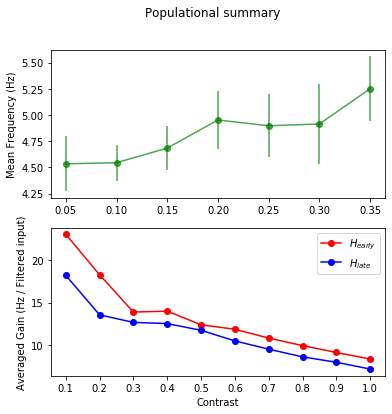

In [205]:
fig, axe = plt.subplots(2,1, figsize=(6,6))

contrasts_l = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
axe[0].errorbar(contrasts_l, [np.mean(each_data[2]) for each_data in data if each_data[0] in contrasts_l], fmt='-o', 
                yerr=[sem(each_data[2]) for each_data in data if each_data[0] in contrasts_l], color='green', alpha=0.7)
axe[0].set_ylabel('Mean Frequency (Hz)')
axe[0].set_xticks(contrasts_l)

contrasts_nl = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
axe[1].plot(contrasts_nl, [np.mean(each_data[1]['he']) for each_data in data if each_data[0] in contrasts_nl], '-o', color='red', label=r'$H_{early}$')
axe[1].plot(contrasts_nl, [np.mean(each_data[1]['hl']) for each_data in data if each_data[0] in contrasts_nl], '-o', color='blue', label=r'$H_{late}$')
axe[1].legend()
axe[1].set_ylabel('Averaged Gain (Hz / Filtered input)')

axe[1].set_xlabel('Contrast')
axe[1].set_xticks(contrasts_nl)

fig.suptitle('Populational summary')

plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/population.png', dpi=300,  bbox_inches = "tight")